In [1]:
import requests
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
zips = pd.read_csv('zipcodes.csv')
df = pd.read_csv('df.csv')

In [3]:
df.head()

,arresting_agency,bail_type,bail_amt,re-entry,race,gender,city,state,zip,age,booking_days,treatment_days,mental_health
0,GARDNER P.D.,SUR,5000.0,1,W,M,Lawrence,KS,66046-3250,37.0,3.0,-1.0,0
1,OVERLAND PARK P.D.,SUR,1500.0,0,W,M,Overland Park,KS,66212,50.0,1.0,-1.0,0
2,OLATHE P.D.,SUR,2500.0,0,W,M,Shawnee,KS,66226,39.0,50.0,-1.0,0
3,LENEXA P.D.,CA,5000.0,1,W,M,NaN,NaN,NaN,46.0,13.0,-1.0,0
4,JOHNSON COUNTY SHERIFF'S DEPARTMENT,SUR,7500.0,1,W,F,Shawnee,KS,66227,42.0,13.0,-1.0,0


In [4]:
df.shape

(9823, 13)

In [5]:
def alter_zip(x):

    x = str(x)
    if len(x)==3:
        x = "00" + x
    return x

In [6]:
def to_lat_lon(table, ziptable):

	
	ziptable['zip'] = ziptable['zip'].apply(lambda x: alter_zip(x))   
	ziptable = ziptable.drop(['city', 'state', 'timezone','dst'], axis=1) 
	table = pd.merge(table, ziptable, on ='zip')

	return table

In [7]:
def get_fips(table):


	fips = []
	for i, row in table.iterrows():
	    lat = row['latitude']
	    lon = row['longitude']
	    url = 'https://geo.fcc.gov/api/census/block/find?latitude={}&longitude={}&format=json'.format(lat,lon)
	    r= requests.get(url)
	    file = r.json()
	    if r:
	        code = file['Block']["FIPS"]
	        fips.append(code)
	    else:
	        fips.append(None)
	table['fips'] = fips

In [19]:
new = to_lat_lon(df,zips)

In [22]:
get_fips(new)

In [9]:
new.head()

,Unnamed: 0,arresting_agency,bail_type,bail_amt,re-entry,race,gender,city,state_x,zip,...,booking_days,treatment_days,mental_health,latitude,longitude,fips,blockgroup,county,state_y,tract
0,0,OVERLAND PARK P.D.,SUR,1500.0,0,W,M,Overland Park,KS,66212,...,1.0,-1.0,0,38.959606,-94.68189,200910518033010,3,91,20,51803
1,1,JOHNSON COUNTY SHERIFF'S DEPARTMENT,SUR,2500.0,1,W,M,Overland Park,KS,66212,...,256.0,-1.0,0,38.959606,-94.68189,200910518033010,3,91,20,51803
2,2,JOHNSON COUNTY SHERIFF'S DEPARTMENT,SUR,25000.0,0,W,M,Overland Park,KS,66212,...,10.0,-1.0,0,38.959606,-94.68189,200910518033010,3,91,20,51803
3,3,LENEXA P.D.,SUR,25000.0,0,W,M,Overland Park,KS,66212,...,0.0,676.0,1,38.959606,-94.68189,200910518033010,3,91,20,51803
4,4,JOHNSON COUNTY SHERIFF'S DEPARTMENT,SUR,3500.0,0,W,M,Overland Park,KS,66212,...,0.0,-1.0,0,38.959606,-94.68189,200910518033010,3,91,20,51803


In [8]:
def break_down(table):

	temp = np.array(table['fips'])
	fips = [x for x in temp if x!=None]
	state = [x[:2] for x in temp if x!=None]
	county = [x[2:5] for x in temp if x!=None]
	tract = [x[5:11] for x in temp if x!=None]
	blockgroup = [x[11:12] for x in temp if x!=None]
	fips_df = pd.DataFrame({'fips' : fips, 'state' : state, 'county' : county, 'tract' : tract, 'blockgroup' : blockgroup })
	table = pd.merge(table, fips, on = 'fips')
    
	return fips_df

In [12]:
fips_df = break_down(new)

In [17]:
fips_df.shape

(8335, 20)

In [37]:
fips_df.head()

,blockgroup,county,fips,state,tract
0,3,091,200910518033010,20,051803
1,3,091,200910518033010,20,051803
2,3,091,200910518033010,20,051803
3,3,091,200910518033010,20,051803
4,3,091,200910518033010,20,051803


In [41]:
unique_fips = fips_df.drop_duplicates()

In [42]:
unique_fips.shape

(244, 5)

In [44]:
withfips = pd.merge(new, unique_fips, on = 'fips')

In [8]:
withfips = pd.read_csv("with_fips.csv")

In [9]:
withfips = withfips.drop("Unnamed: 0", axis=1)

In [10]:
withfips.shape

(8335, 20)

In [11]:
withfips.head()

,arresting_agency,bail_type,bail_amt,re-entry,race,gender,city,state_x,zip,age,booking_days,treatment_days,mental_health,latitude,longitude,fips,blockgroup,county,state_y,tract
0,OVERLAND PARK P.D.,SUR,1500.0,0,W,M,Overland Park,KS,66212,50.0,1.0,-1.0,0,38.959606,-94.68189,200910518033010,3,91,20,51803
1,JOHNSON COUNTY SHERIFF'S DEPARTMENT,SUR,2500.0,1,W,M,Overland Park,KS,66212,37.0,256.0,-1.0,0,38.959606,-94.68189,200910518033010,3,91,20,51803
2,JOHNSON COUNTY SHERIFF'S DEPARTMENT,SUR,25000.0,0,W,M,Overland Park,KS,66212,58.0,10.0,-1.0,0,38.959606,-94.68189,200910518033010,3,91,20,51803
3,LENEXA P.D.,SUR,25000.0,0,W,M,Overland Park,KS,66212,53.0,0.0,676.0,1,38.959606,-94.68189,200910518033010,3,91,20,51803
4,JOHNSON COUNTY SHERIFF'S DEPARTMENT,SUR,3500.0,0,W,M,Overland Park,KS,66212,32.0,0.0,-1.0,0,38.959606,-94.68189,200910518033010,3,91,20,51803


In [12]:
def info_retrieve(table):
    asc = []
    for i, row in table.iterrows():
        fips = row['fips']
        blkgrp = row['blockgroup']
        state = row['state_y']
        county = row['county']
        tract = row['tract']
        
        search_term = 'B19301_001E,B17021_001E,B19001_001E,B25087_001E,B14005_001E,B09002_001E,B19056_001E,B99104_001E,B21002_001E,B15002_001E,B25075_001E,B19059_001E,B25070_001E'
        key = '209a50c6b62ff53a635f9ae4a6e6cc5d3467c7d7'
        address = 'https://api.census.gov/data/2010/acs5?get={}&for=block+group:{}&in=state:{}+county:{}+tract:{}&key={}'.format(search_term, blkgrp, state, county, tract, key)
 
        json_results = requests.get(address)
        json_dict = json_results.json()
        
        if json_results:
            info = [fips] + json_dict[1]
            asc.append(info)
        else:
            asc.append([None]*len(json_dict[1]))

            
        print("getting...")
            
    colnames = ['fips','per_capita_income', 'poverty_stat', 'household_income', 'mortgage_stat', 'school_enrollment_16-19', 'own_children_under18', 'SSI_income', 'grandparent_care', 'military_service', 'education_25', 'property_value_occupied', 'retirement_income', 'rent_over_income', 'state', 'county', 'tract', 'blockgroup']
    print("writing to the dataframe")
    asc_df = pd.DataFrame(asc, columns = colnames)
    unique_asc = asc_df.drop_duplicates()
    
    #total_df = pd.merge(table, unique_asc, left_on = 'fips', right_on = 'fips')
    
    return unique_asc

In [13]:
test = withfips[:10]

In [14]:
test_asc = info_retrieve(test)

getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
writing to the dataframe


In [15]:
test_asc

,fips,per_capita_income,poverty_stat,household_income,mortgage_stat,school_enrollment_16-19,own_children_under18,SSI_income,grandparent_care,military_service,education_25,property_value_occupied,retirement_income,rent_over_income,state,county,tract,blockgroup
0,200910518033010,26836,1118,456,364,167,175,456,692,66,776,364,456,92,20,091,051803,3


In [16]:
unique_asc = info_retrieve(withfips)

getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...

In [17]:
unique_asc.head()

,fips,per_capita_income,poverty_stat,household_income,mortgage_stat,school_enrollment_16-19,own_children_under18,SSI_income,grandparent_care,military_service,education_25,property_value_occupied,retirement_income,rent_over_income,state,county,tract,blockgroup
0,200910518033010,26836,1118,456,364,167,175,456,692,66,776,364,456,92,20,091,051803,3
437,200910526033009,31591,2962,918,896,174,1042,918,1666,180,1727,896,918,22,20,091,052603,3
479,200910526011028,36935,1498,596,571,44,352,596,991,74,1080,571,596,25,20,091,052601,1
515,200910528012016,36605,1571,475,461,82,576,475,847,77,958,461,475,14,20,091,052801,2
1760,200910518013025,70491,1529,581,573,81,364,581,1055,164,1065,573,581,8,20,091,051801,3


In [21]:
unique_asc.to_csv("unique_asc.csv")

In [22]:
unique_asc.shape

(244, 18)

In [39]:
asc_cols = list(unique_asc.columns)
df_cols = list(total_df.columns)
cols = list(set(asc_cols).difference(set(df_cols)))

unique_asc = unique_asc.drop(cols+['state'], axis=1)

In [40]:
total_df = pd.merge(withfips, unique_asc, left_on = 'fips', right_on = 'fips')

In [41]:
total_df.shape

(8335, 33)

In [42]:
total_df.head()

,arresting_agency,bail_type,bail_amt,re-entry,race,gender,city,state_x,zip,age,...,mortgage_stat,school_enrollment_16-19,own_children_under18,SSI_income,grandparent_care,military_service,education_25,property_value_occupied,retirement_income,rent_over_income
0,OVERLAND PARK P.D.,SUR,1500.0,0,W,M,Overland Park,KS,66212,50.0,...,364,167,175,456,692,66,776,364,456,92
1,JOHNSON COUNTY SHERIFF'S DEPARTMENT,SUR,2500.0,1,W,M,Overland Park,KS,66212,37.0,...,364,167,175,456,692,66,776,364,456,92
2,JOHNSON COUNTY SHERIFF'S DEPARTMENT,SUR,25000.0,0,W,M,Overland Park,KS,66212,58.0,...,364,167,175,456,692,66,776,364,456,92
3,LENEXA P.D.,SUR,25000.0,0,W,M,Overland Park,KS,66212,53.0,...,364,167,175,456,692,66,776,364,456,92
4,JOHNSON COUNTY SHERIFF'S DEPARTMENT,SUR,3500.0,0,W,M,Overland Park,KS,66212,32.0,...,364,167,175,456,692,66,776,364,456,92


In [43]:
total_df.columns

Index(['arresting_agency', 'bail_type', 'bail_amt', 're-entry', 'race',
       'gender', 'city', 'state_x', 'zip', 'age', 'booking_days',
       'treatment_days', 'mental_health', 'latitude', 'longitude', 'fips',
       'blockgroup', 'county', 'state_y', 'tract', 'per_capita_income',
       'poverty_stat', 'household_income', 'mortgage_stat',
       'school_enrollment_16-19', 'own_children_under18', 'SSI_income',
       'grandparent_care', 'military_service', 'education_25',
       'property_value_occupied', 'retirement_income', 'rent_over_income'],
      dtype='object')

In [44]:
def missing_vals(df):

	# make new columns indicating what will be imputed
	cols_with_missing = [col for col in df.columns if df[col].isnull().any()]

	for col in cols_with_missing:
		#df[col + '_was_missing'] = df[col].isnull()
		print('{} has missing values'.format(col))

	return cols_with_missing

In [45]:
missing_vals(total_df)

state_x has missing values
per_capita_income has missing values


['state_x', 'per_capita_income']

In [46]:
total_df.isnull().sum()

arresting_agency            0
bail_type                   0
bail_amt                    0
re-entry                    0
race                        0
gender                      0
city                        0
state_x                     1
zip                         0
age                         0
booking_days                0
treatment_days              0
mental_health               0
latitude                    0
longitude                   0
fips                        0
blockgroup                  0
county                      0
state_y                     0
tract                       0
per_capita_income          14
poverty_stat                0
household_income            0
mortgage_stat               0
school_enrollment_16-19     0
own_children_under18        0
SSI_income                  0
grandparent_care            0
military_service            0
education_25                0
property_value_occupied     0
retirement_income           0
rent_over_income            0
dtype: int

In [29]:
def plot_df(df, columns, save=False):

	for col in columns:
		count_column = df[col].value_counts()
		plt.figure(figsize=(len(count_column), 5))
		column_figure = sns.barplot(count_column.index, count_column.values, alpha=0.8)
		plt.title('{} values'.format(col))
		plt.ylabel('Number of Counts', fontsize=12)
		plt.xlabel(col, fontsize=12) 
		
		if save: 
			column_figure.figure.savefig('{}.png'.format(col))
			print('figure is saved as a file ~.png')
		else:
			plt.show()

	return None

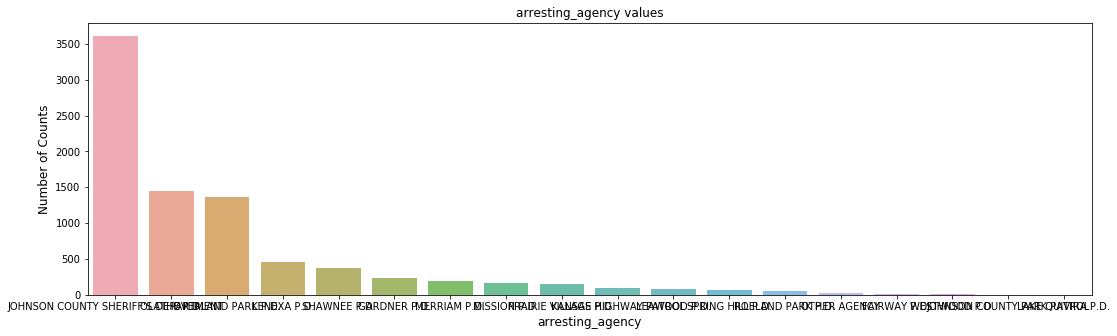

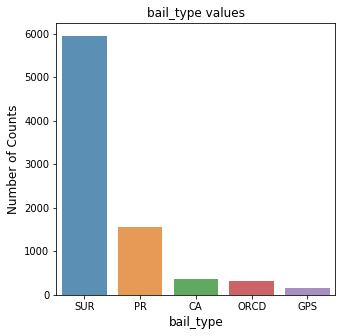

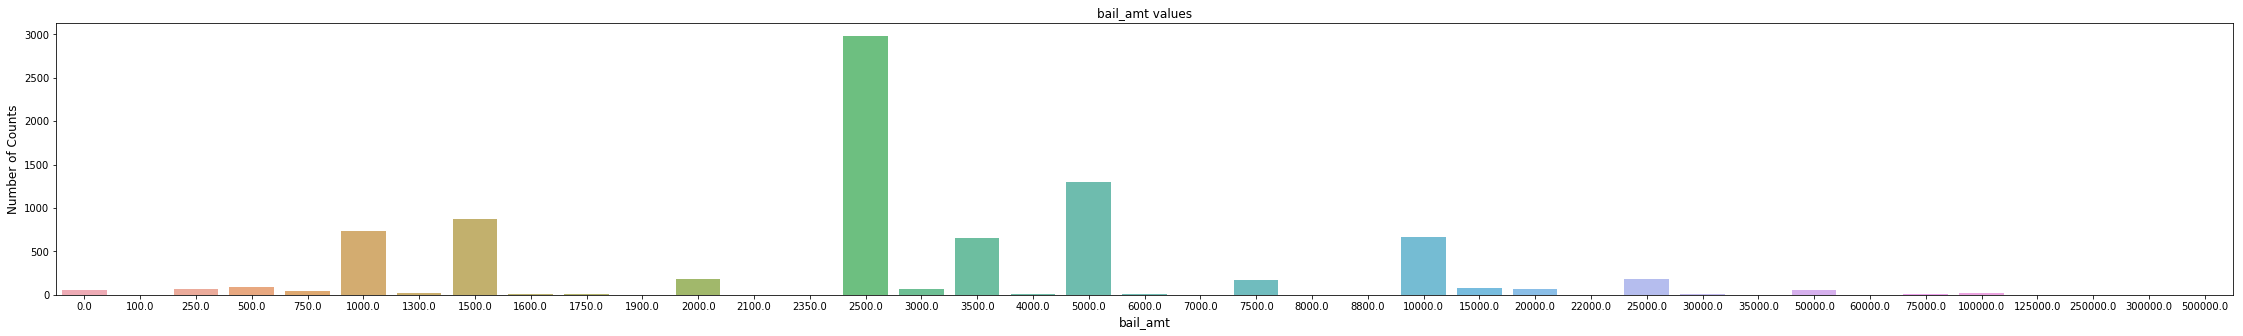

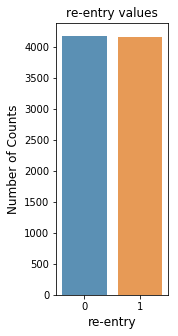

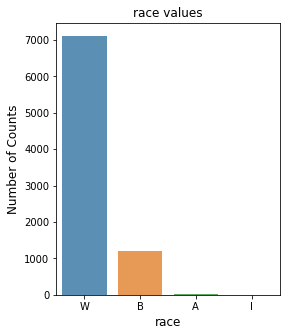

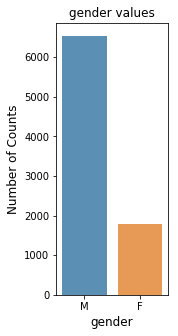

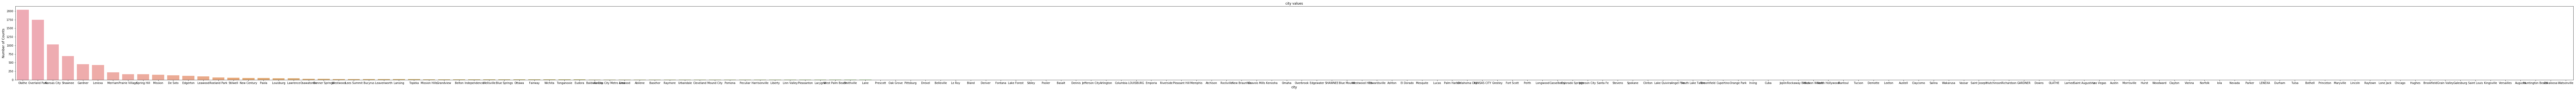

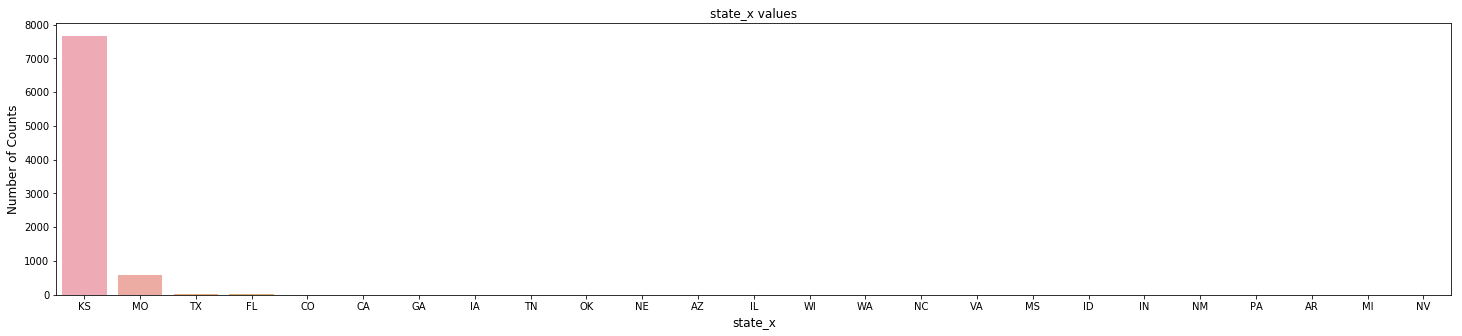

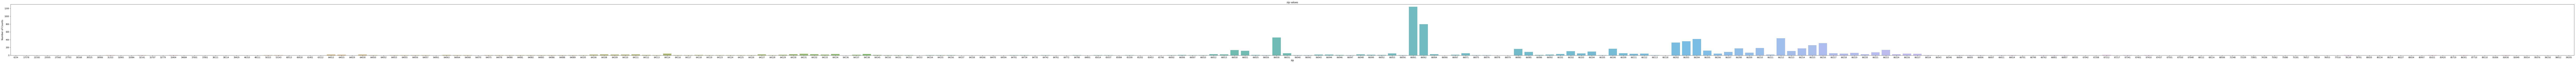

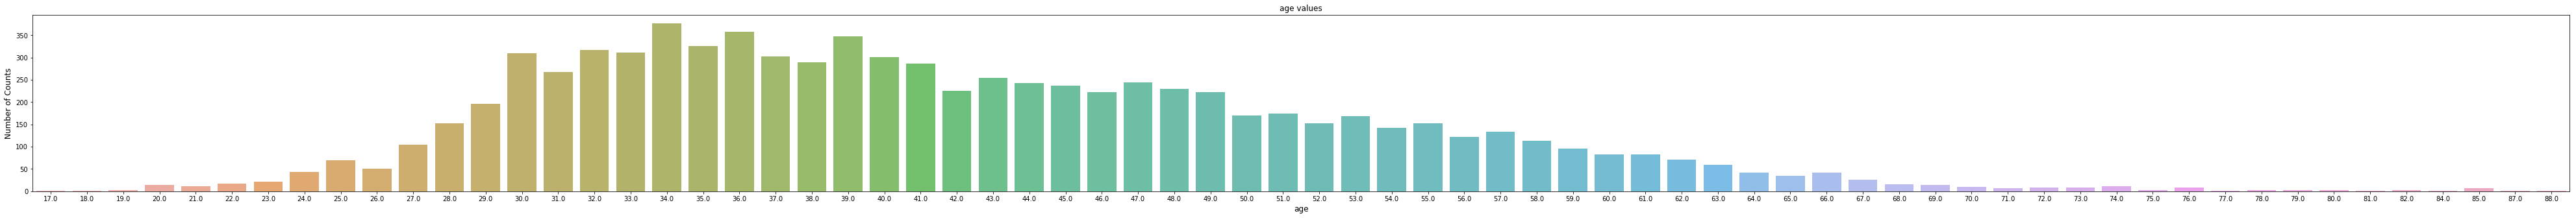

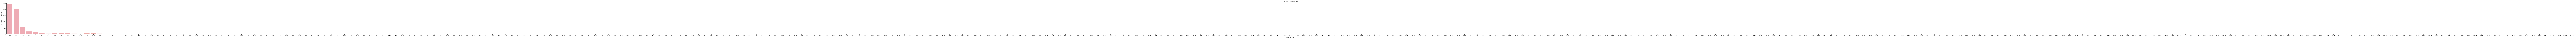

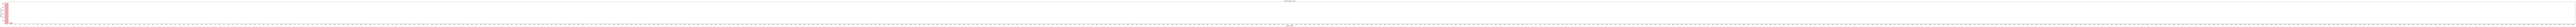

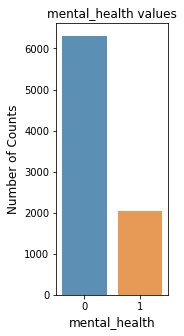

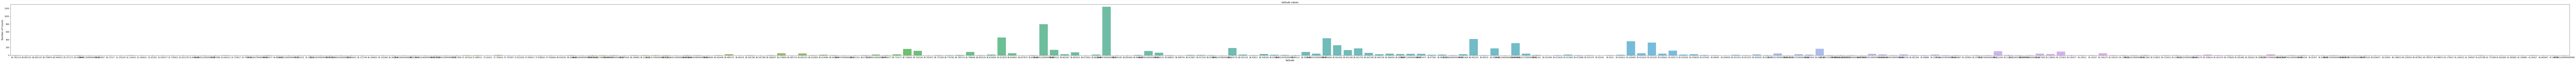

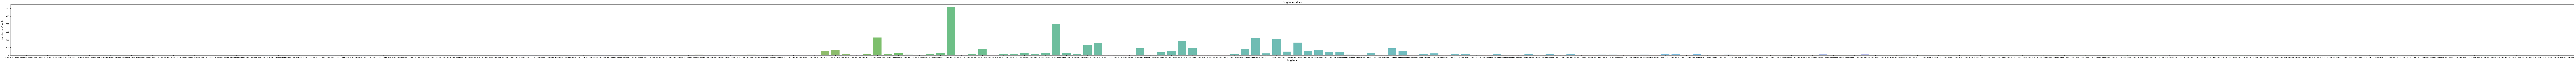

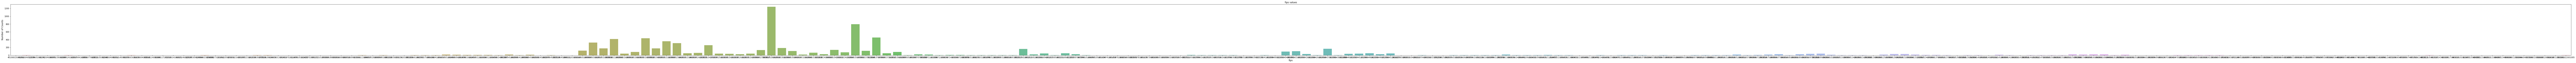

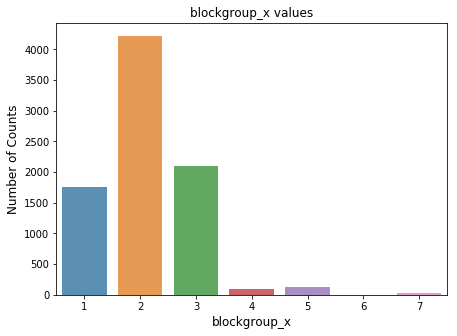

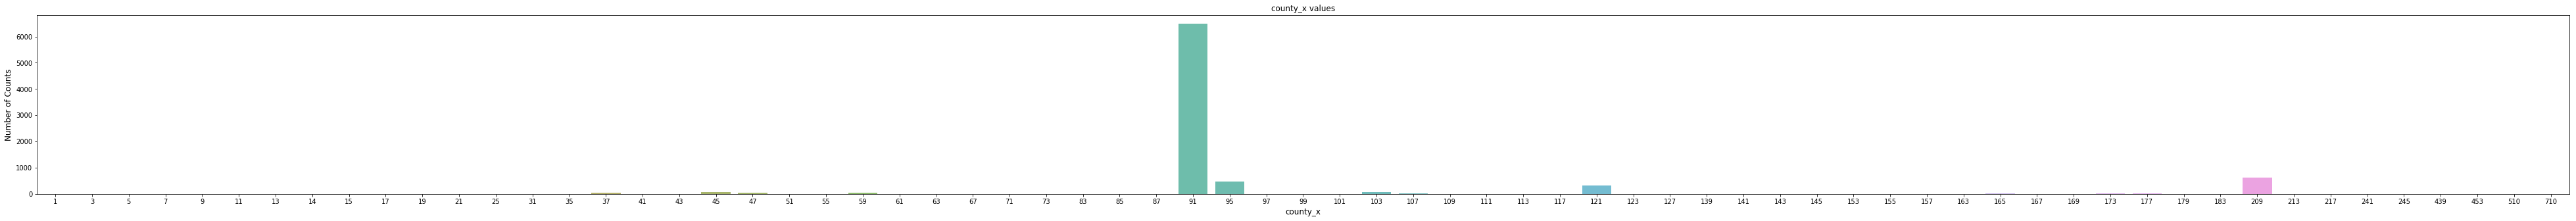

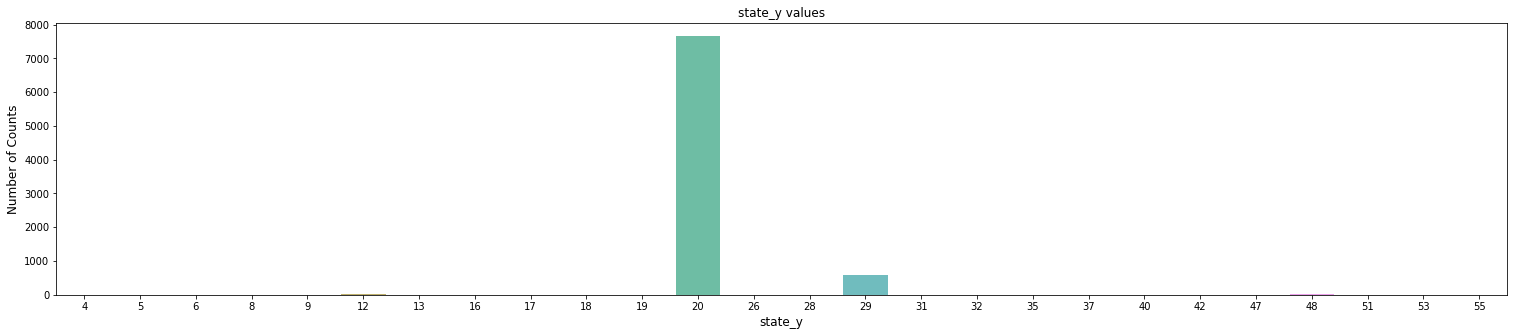

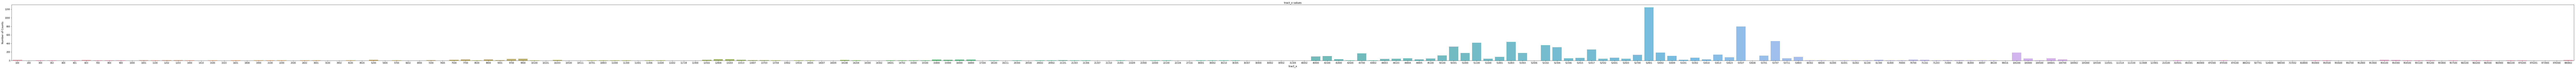

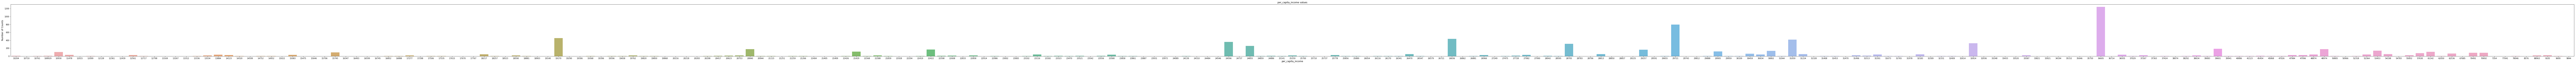

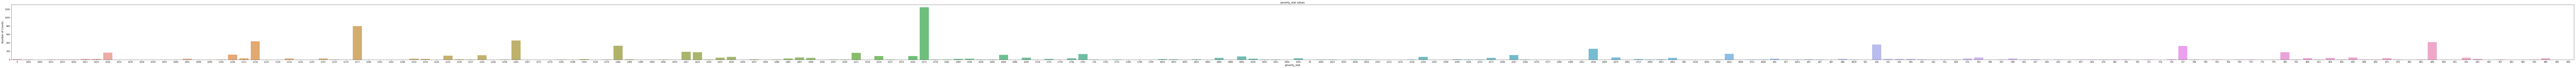

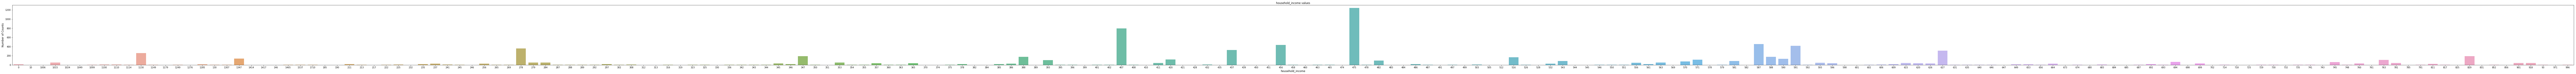

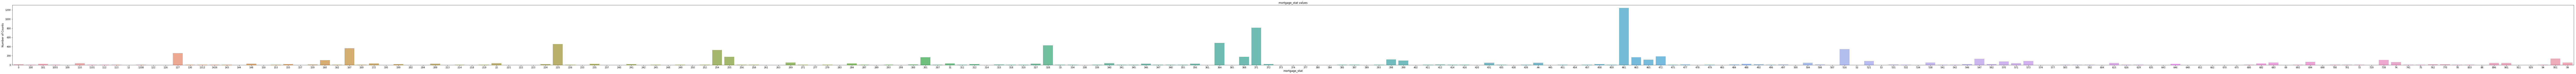

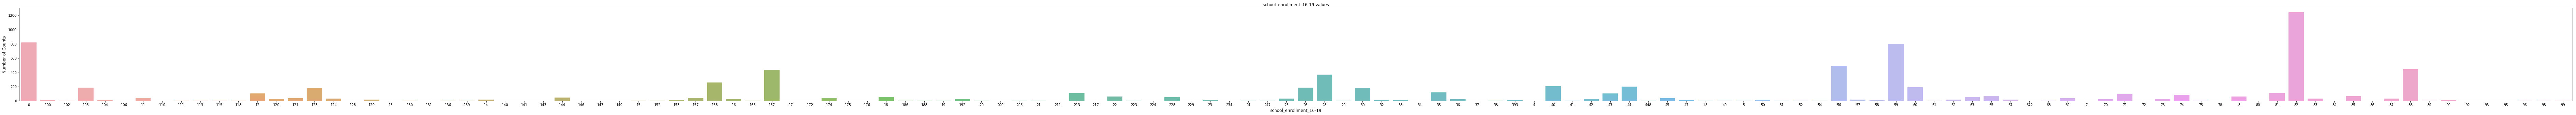

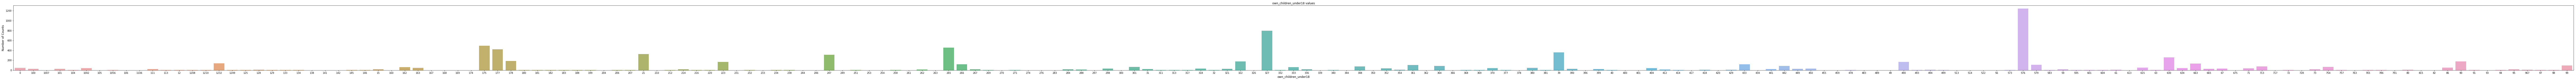

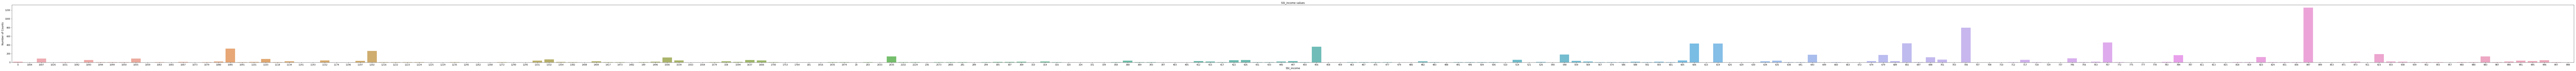

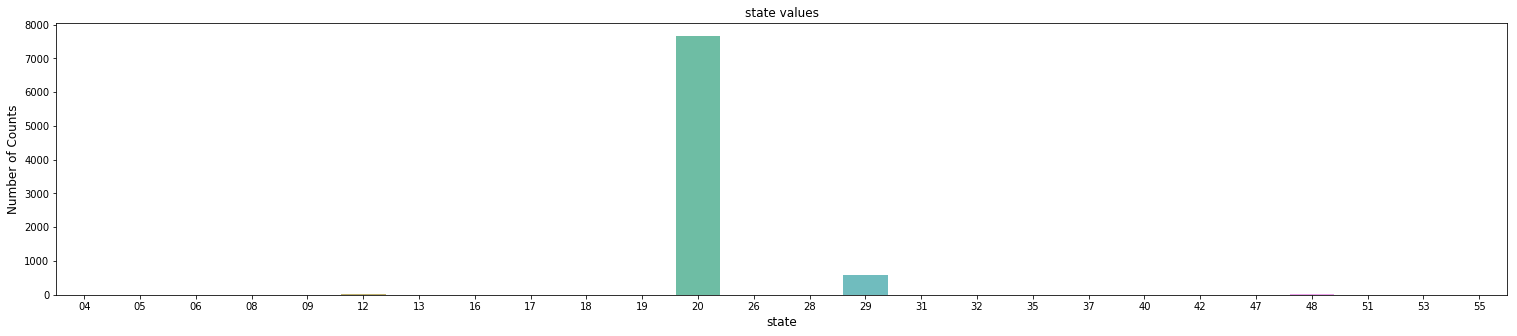

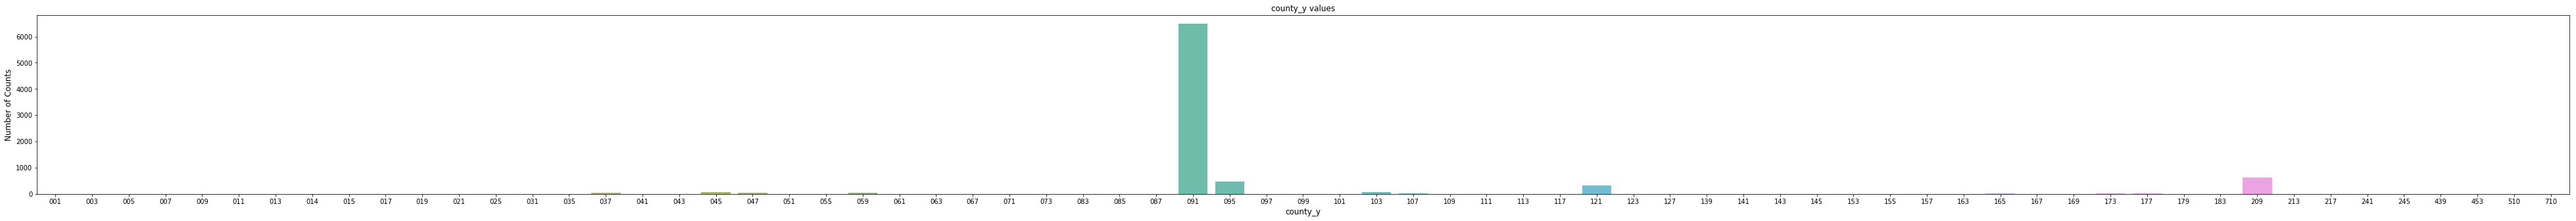

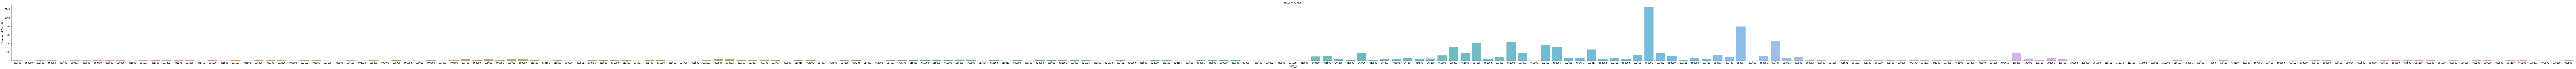

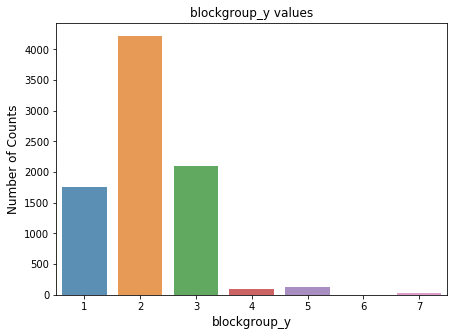

In [30]:
plot_df(total_df, total_df.columns)

In [47]:
total_df.nunique()

arresting_agency            18
bail_type                    5
bail_amt                    39
re-entry                     2
race                         4
gender                       2
city                       170
state_x                     25
zip                        244
age                         70
booking_days               399
treatment_days             580
mental_health                2
latitude                   244
longitude                  244
fips                       244
blockgroup                   7
county                      69
state_y                     26
tract                      223
per_capita_income          241
poverty_stat               226
household_income           209
mortgage_stat              209
school_enrollment_16-19    134
own_children_under18       193
SSI_income                 209
grandparent_care           217
military_service           156
education_25               221
property_value_occupied    209
retirement_income          209
rent_ove